## Imports:

In [2]:
import cv2
import matplotlib.pyplot as plt
import dlib
#from google.colab.patches import cv2_imshow
from imutils import face_utils
import imutils
import argparse
import numpy as np
import pandas as pd
import os 
from imutils import paths



from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers.legacy import Adam

from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical ,plot_model
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

## Downloading the Data:

In [ ]:
!rm -vr ~/.kaggle
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json
!chmod 777 ~/.kaggle/kaggle.json

rm: cannot remove '/root/.kaggle': No such file or directory


In [ ]:
api_token = {"username":"marianassief","key":"7330384a4d44b59212aeabd5fcb179c4"}

import json
with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
%%capture
!kaggle datasets download -d pranavsingaraju/facemask-detection-dataset-20000-images
!unzip /content/facemask-detection-dataset-20000-images.zip

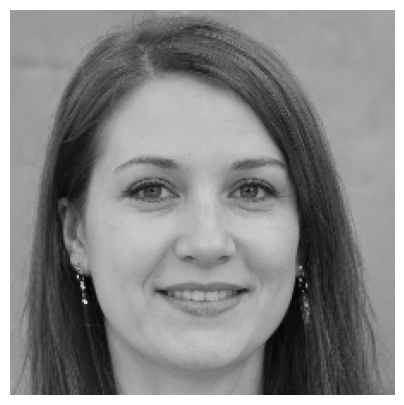

In [ ]:
file='/content/new_without_mask/seed0000.png'
without_mask_1 = cv2.imread(file)
plt.figure(figsize =(5,5))
plt.imshow(without_mask_1)
plt.axis('off')
plt.show()

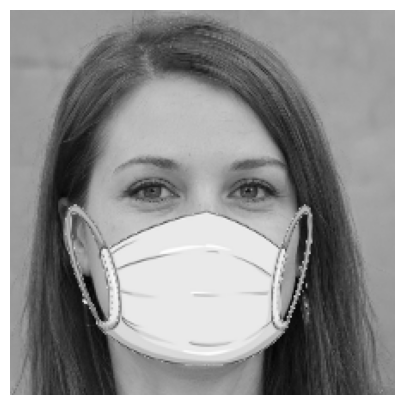

In [ ]:
file='/content/new_with_mask/with-mask-default-mask-seed0000.png'
with_mask_1 = cv2.imread(file)
plt.figure(figsize =(5,5))
plt.imshow(with_mask_1)
plt.axis('off')
plt.show()

In [36]:
dataset1= "/content/new_with_mask"
dataset2= "/content/new_without_mask"

imagePaths=list(imutils.paths.list_images(dataset1))
imagePaths2=list(imutils.paths.list_images(dataset2))
image_path=imagePaths+ imagePaths2


In [37]:
data=[]
labels=[]

for i in image_path:
    label=i.split(os.path.sep)[-2]
    labels.append(label)
    image = load_img(i,target_size=(96,96))
    image = img_to_array(image)
    image = preprocess_input(image)
    data.append(image)

In [38]:
data = np.array(data,dtype='float32')
labels = np.array(labels)

In [39]:
lb=LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)
labels

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [40]:
len(labels)

20000

In [41]:
train_Xx,test_X,train_Yy,test_Y = train_test_split(data,labels,test_size=0.20,random_state=123,stratify=labels)

In [42]:
train_X,val_X,train_Y,val_Y = train_test_split(train_Xx,train_Yy,test_size=0.10,random_state=123,stratify=train_Yy)

In [43]:
# Build Model
input_shape=(96,96,3)
input_image = Input(shape=input_shape)

# 1st Conv layer
model = Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=input_shape)(input_image)
model = MaxPooling2D((2, 2),padding='same')(model)
# 2nd Conv layer
model = Conv2D(32, (3, 3), activation='relu', padding='same')(model)
model = MaxPooling2D((2, 2),padding='same')(model)
# 3rd Conv layer
model = Conv2D(64, (3, 3), activation='relu', padding='same')(model)
model = MaxPooling2D((2, 2),padding='same')(model)
# 4th Conv layer
model = Conv2D(128, (3, 3), activation='relu', padding='same')(model)
model = MaxPooling2D((2, 2),padding='same')(model)
# 5th Conv layer
model = Conv2D(256, (3, 3), activation='relu', padding='same')(model)
model = MaxPooling2D((2, 2),padding='same')(model)
# FC layers
model = Flatten()(model)
#model = Dense(1024, kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(model)
model = Dense(1024)(model)
#model = Dropout(0.2)(model)

#model = Dense(64, kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(model)
model = Dense(64)(model)
#model = Dropout(0.2)(model)

output= Dense(2, activation='softmax')(model)

model = Model(inputs=[input_image], outputs=[output])

In [44]:
lr=0.0005
Epochs=100
BS=32

opt=Adam(learning_rate=lr,decay=lr/Epochs)

In [45]:
model.compile(loss='binary_crossentropy',optimizer=opt,metrics=['accuracy'])

In [ ]:
modell_history = model.fit(train_X, train_Y, epochs=20, batch_size=BS, validation_data=(val_X, val_Y))

In [ ]:
modell_history

## Pre-processing:

In [ ]:
%%capture
!kaggle datasets download -d sergiovirahonda/shape-predictor-68-face-landmarksdat
!unzip /content/shape-predictor-68-face-landmarksdat.zip

In [ ]:
predictor=dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
face_detector = dlib.get_frontal_face_detector()

In [ ]:
def draw_image(image) :
    dets = face_detector(image, 1)
    for (idx, det) in enumerate(dets):
                # Get x_min, y_min, x_max, y_max, conf
                x_min = det.left()
                y_min = det.top()
                x_max = det.right()-x_min
                y_max = det.bottom()-y_min
                # conf = det.confidence
                print(det)
                print(x_min,y_min,x_max,y_max)
                
                shape = predictor(image, det)
                tdx,tdy=shape.part(30).x, shape.part(30).y
                bbox_height, bbox_width = image.shape[:2]
              
                cv2.destroyAllWindows()
                cv2_imshow(image )
    cv2.destroyAllWindows() 

[(53, 67) (182, 196)]
53 67 129 129


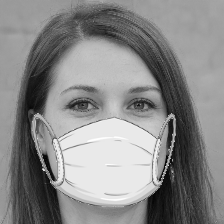

In [ ]:
draw_image(with_mask_1)

In [ ]:
def draw_mesh(img):
    image=img
    rects = face_detector(image, 1)
    print(rects)
    for (i, rect) in enumerate(rects):
      # determine the facial landmarks for the face region, then convert the facial landmark (x, y)-coordinates to a NumPy array
      shape = predictor(image, rect)
      shape = face_utils.shape_to_np(shape)
       
      (x, y, w, h) = face_utils.rect_to_bb(rect)
      #cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
      #cv2.putText(image, "Face #{}".format(i + 1), (x - 10, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
      # loop over the (x, y)-coordinates for the facial landmarks and draw them on the image
      for (x, y) in shape:
        cv2.circle(image, (x, y), 1, (0, 0, 255), -1)
    # show the output image with the face detections + facial landmarks
      return image
      #cv2_imshow(image )

rectangles[[(53, 67) (182, 196)]]


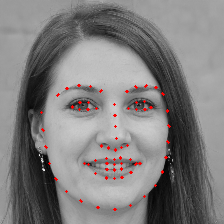

In [ ]:
res1=draw_mesh(without_mask_1)
cv2_imshow(res1 )

rectangles[[(53, 67) (182, 196)]]


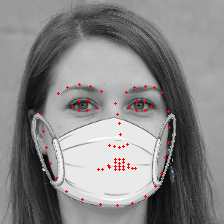

In [ ]:
res2=draw_mesh(with_mask_1)
cv2_imshow(res2 )

In [ ]:
res1-res2

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

#Mediapipe

In [ ]:
%%capture
!git clone https://github.com/AssemblyAI-Examples/mediapipe-python.git
!pip install mediapipe
!pip install PyQt5
!pip install ipython==7.32.0

In [ ]:
import mediapipe

In [ ]:
def draw_meshonface(dir,random_file,color,image):

  faceModule = mediapipe.solutions.face_mesh

  with faceModule.FaceMesh(static_image_mode=True) as faces:
      # loading the image
      #image = cv2.imread(dir+random_file)
      # processing the face to extract the landmark points (468 point) for each x,y,z
      results = faces.process(image)
      if results.multi_face_landmarks != None: 
        # looping over the faces in the image
        for face in results.multi_face_landmarks:
            for landmark in face.landmark:
                x = landmark.x
                y = landmark.y
                
                # note: the x and y values are scaled to the their width and height so we will get back their actual value in the image
                shape = image.shape
                relative_x = int(x * shape[1])
                relative_y = int(y * shape[0])
                #cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
                # cv2.putText(image, str(relative_y), (int(relative_x),int(relative_y)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0,255,0), 2)
                cv2.circle(image, (relative_x, relative_y), radius=1, color=color, thickness=-1)
  return image

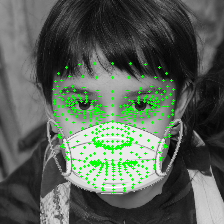

In [ ]:
dir='/content/new_with_mask/'
rfile='with-mask-default-mask-seed0099.png'
color=(0, 255, 0)
mask_img = draw_meshonface(dir,rfile,color)
cv2_imshow(mask_img)

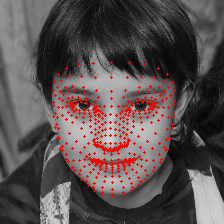

In [ ]:
dir='/content/new_without_mask/'
rfile='seed0099.png'
color=(0, 0, 255)
withoutmask_img = draw_meshonface(dir,rfile,color)
cv2_imshow(withoutmask_img)

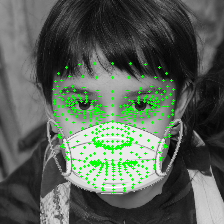

In [ ]:
color=(255, 0, 0)
img = draw_meshonface(dir,rfile,color,mask_img)
cv2_imshow(img)

In [ ]:
img

array([[[143, 143, 143],
        [147, 147, 147],
        [146, 146, 146],
        ...,
        [ 73,  73,  73],
        [ 73,  73,  73],
        [ 68,  68,  68]],

       [[147, 147, 147],
        [146, 146, 146],
        [144, 144, 144],
        ...,
        [ 73,  73,  73],
        [ 73,  73,  73],
        [ 77,  77,  77]],

       [[140, 140, 140],
        [144, 144, 144],
        [143, 143, 143],
        ...,
        [ 73,  73,  73],
        [ 75,  75,  75],
        [ 77,  77,  77]],

       ...,

       [[ 29,  29,  29],
        [ 31,  31,  31],
        [ 33,  33,  33],
        ...,
        [203, 203, 203],
        [204, 204, 204],
        [201, 201, 201]],

       [[ 33,  33,  33],
        [ 35,  35,  35],
        [ 36,  36,  36],
        ...,
        [210, 210, 210],
        [205, 205, 205],
        [202, 202, 202]],

       [[ 38,  38,  38],
        [ 38,  38,  38],
        [ 36,  36,  36],
        ...,
        [209, 209, 209],
        [206, 206, 206],
        [201, 201, 201]]

In [ ]:
withoutmask_img-mask_img

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)